In [1]:
import xarray as xr
import numpy as np
import gfdl_utils as gu
import matplotlib.pyplot as plt
import mat73
import glob

In [2]:
def calc_asc113E(config,varstr,upperdepth=0):
    if config=='ESM4':
        configname = 'ESM4/piControl'
        if varstr=='umo':
            timestr = '0101-0270'
        elif varstr=='uo':
            timestr = '0121-0220'
        timeslice = slice('0121-07-02','0220-07-02')
    elif config=='CM4':
        configname = 'piControl_output'
        if varstr=='umo':
            timestr = '0251-0405'
        elif varstr=='uo':
            timestr = '0281-0380'
        timeslice = slice('0281-07-02','0380-07-02')

    rootdir = '/net2/Rebecca.Beadling/southern_ocean_fafmip/'+configname+'/'
    filename = 'ocean_annual_z.'+timestr+'.'+varstr+'.nc'
    select = {
        'time':timeslice,
        'yh':slice(-65.5,-62),
        'z_l':slice(upperdepth,7000)
             }
    lon = -246.7
    var = (xr.open_dataset(rootdir+filename,
                         drop_variables=['average_DT', 'average_T1', 'average_T2'],
                         use_cftime=True)[varstr]
           .sel(**select)
           .sel(xq=lon,method='nearest')
          )
    return var

In [3]:
def calc_asc113E_sose(upperdepth=0,transport=False):
    rootdir = '/archive/Rebecca.Beadling/SOSE_to_transfer_new/'
    filename = 'UvelForEllyn.mat'
    dict_uvel = mat73.loadmat(rootdir+filename)
    uvel = xr.DataArray(dict_uvel["U"],dims={"xq":dict_uvel["xg"], "yh":dict_uvel["yc"], "z_l":dict_uvel["z"]})
    uvel = uvel.assign_coords({"xq":dict_uvel["xg"], "yh":dict_uvel["yc"], "z_l":dict_uvel["z"]})
    select = {
            'yh':slice(-65.5,-62),
            'z_l':slice(upperdepth,-7000)
                 }
    lon = 113.3
    uo = (uvel
          .sel(**select)
          .sel(xq=lon,method='nearest')
         )
    
    if transport:
        ## Load and assign grid data
        dict_grid = mat73.loadmat(rootdir+'grid.mat')
        # Grid data has to be chopped in the Y dimension

        #hFacW
        hFacW = xr.DataArray(dict_grid["hFacW"],
                             dims=['xq','yh','z_l'])
        hFacW = (hFacW
                 .isel(yh=slice(0,643))
                 .assign_coords({
                     "xq":dict_uvel["xg"],
                     "yh":dict_uvel["yc"],
                     "z_l":dict_uvel["z"]
                 })
                )

        #DYG
        DYG = xr.DataArray(dict_grid["DYG"],
                             dims=['xq','yh'])
        DYG = (DYG
                 .isel(yh=slice(0,643))
                 .assign_coords({
                     "xq":dict_uvel["xg"],
                     "yh":dict_uvel["yc"]
                 })
                )

        #DRF
        DRF = xr.DataArray(dict_grid["DRF"],
                             dims=['z_l'])
        DRF = (DRF
                 .assign_coords({
                     "z_l":dict_uvel["z"],
                 })
                )
        
        # Calculate transport
        area = hFacW*DYG*DRF
        uo = uo*area.sel(**select).sel(xq=lon,method='nearest')
        
    return uo.where(uo!=0,np.nan)

## Transports

In [4]:
umo_esm4 = calc_asc113E('ESM4','umo',upperdepth=0)
umo_cm4 = calc_asc113E('CM4','umo',upperdepth=0)
umo_sose = calc_asc113E_sose(upperdepth=0,transport=True)

In [9]:
# Cumulative sum from south
umo_esm4_cumsum = umo_esm4.sum('z_l').cumsum('yh').min('yh')/(1035*1e6)
umo_cm4_cumsum = umo_cm4.sum('z_l').cumsum('yh').min('yh')/(1035*1e6)
umo_sose_cumsum = umo_sose.sum('z_l').cumsum('yh').min('yh')/(1e6)

umo_esm4_500_cumsum = umo_esm4.sel(z_l=slice(500,7000)).sum('z_l').cumsum('yh').min('yh')/(1035*1e6)
umo_cm4_500_cumsum = umo_cm4.sel(z_l=slice(500,7000)).sum('z_l').cumsum('yh').min('yh')/(1035*1e6)
umo_sose_500_cumsum = umo_sose.sel(z_l=slice(-500,-7000)).sum('z_l').cumsum('yh').min('yh')/(1e6)

mean = {}
mean['esm4_total'] = np.round(umo_esm4_cumsum.mean('time').values,1)
mean['cm4_total'] = np.round(umo_cm4_cumsum.mean('time').values,1)
mean['sose_total'] = np.round(umo_sose_cumsum.values,1)
mean['esm4_500'] = np.round(umo_esm4_500_cumsum.mean('time').values,1)
mean['cm4_500'] = np.round(umo_cm4_500_cumsum.mean('time').values,1)
mean['sose_500'] = np.round(umo_sose_500_cumsum.values,1)

std = {}
std['esm4_total'] = np.round(umo_esm4_cumsum.std('time').values,1)
std['cm4_total'] = np.round(umo_cm4_cumsum.std('time').values,1)
std['esm4_500'] = np.round(umo_esm4_500_cumsum.std('time').values,1)
std['cm4_500'] = np.round(umo_cm4_500_cumsum.std('time').values,1)

In [130]:
# Pure summation
umo_esm4_sum = umo_esm4.sum(['yh','z_l'])/(1035*1e6)
umo_cm4_sum = umo_cm4.sum(['yh','z_l'])/(1035*1e6)
umo_sose_sum = umo_sose.sum(['yh','z_l'])/(1e6)

umo_esm4_500_sum = umo_esm4.sel(z_l=slice(500,7000)).sum(['yh','z_l'])/(1035*1e6)
umo_cm4_500_sum = umo_cm4.sel(z_l=slice(500,7000)).sum(['yh','z_l'])/(1035*1e6)
umo_sose_500_sum = umo_sose.sel(z_l=slice(-500,-7000)).sum(['yh','z_l'])/(1e6)

mean = {}
mean['esm4_total'] = np.round(umo_esm4_sum.mean('time').values,1)
mean['cm4_total'] = np.round(umo_cm4_sum.mean('time').values,1)
mean['sose_total'] = np.round(umo_sose_sum.values,1)
mean['esm4_500'] = np.round(umo_esm4_500_sum.mean('time').values,1)
mean['cm4_500'] = np.round(umo_cm4_500_sum.mean('time').values,1)
mean['sose_500'] = np.round(umo_sose_500_sum.values,1)

std = {}
std['esm4_total'] = np.round(umo_esm4_sum.std('time').values,1)
std['cm4_total'] = np.round(umo_cm4_sum.std('time').values,1)
std['esm4_500'] = np.round(umo_esm4_500_sum.std('time').values,1)
std['cm4_500'] = np.round(umo_cm4_500_sum.std('time').values,1)

In [131]:
print('ESM4')
print('mean : '+str(umo_esm4_sum.mean('time').values)+' Sv')
print('std : '+str(umo_esm4_sum.std('time').values)+' Sv')
print(' ')
print('CM4')
print('mean : '+str(umo_cm4_sum.mean('time').values)+' Sv')
print('std : '+str(umo_cm4_sum.std('time').values)+' Sv')
print(' ')
print('SOSE')
print('mean : '+str(umo_sose_sum.values)+' Sv')

ESM4
mean : -15.721701 Sv
std : 3.9183311 Sv
 
CM4
mean : -6.759485 Sv
std : 4.00315 Sv
 
SOSE
mean : -18.373862 Sv


## Velocity sections

In [10]:
uo_esm4 = calc_asc113E('ESM4','uo',upperdepth=0)
uo_cm4 = calc_asc113E('CM4','uo',upperdepth=0)
uo_sose = calc_asc113E_sose(upperdepth=0)

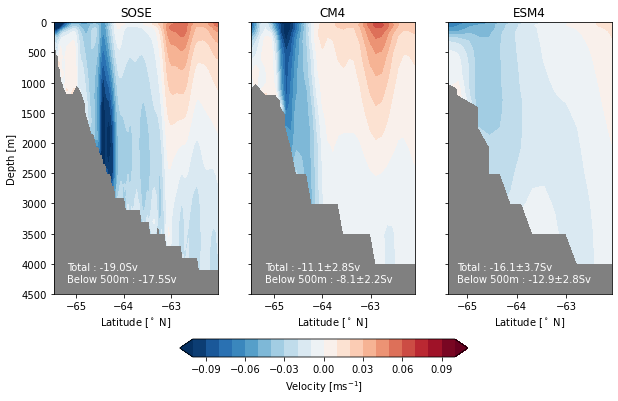

In [12]:
plt_kwargs = {
    'cmap':'RdBu_r',
    # 'shading':'auto',
    'levels':np.arange(-0.1,0.11,0.01),
    # 'vmin':-0.1,'vmax':0.1
    'extend':'both',
}
ylims = [4500,0]

fig,(ax_sose,ax_cm4,ax_esm4)=plt.subplots(figsize=(10,5),ncols=3,subplot_kw={'facecolor':'grey'})

im = ax_sose.contourf(uo_sose['yh'],
                    -1*uo_sose['z_l'],
                    uo_sose.transpose(),
                    **plt_kwargs)
ax_sose.set_ylim(ylims)
ax_sose.set_title('SOSE')
ax_sose.set_ylabel('Depth [m]')
ax_sose.set_xlabel('Latitude [$^\circ$ N]')

im = ax_cm4.contourf(uo_cm4['yh'],
                    uo_cm4['z_l'],
                    uo_cm4.mean('time'),
                    **plt_kwargs)
ax_cm4.set_ylim(ylims)
ax_cm4.set_title('CM4')
ax_cm4.yaxis.set_ticklabels([])
ax_cm4.set_xlabel('Latitude [$^\circ$ N]')

im = ax_esm4.contourf(uo_esm4['yh'],
                    uo_esm4['z_l'],
                    uo_esm4.mean('time'),
                    **plt_kwargs)
ax_esm4.set_ylim(ylims)
ax_esm4.set_title('ESM4')
ax_esm4.yaxis.set_ticklabels([])
ax_esm4.set_xlabel('Latitude [$^\circ$ N]')

cbar_ax = fig.add_axes([0.3, -0.05, 0.4, 0.05])
cb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal');
cb.set_label('Velocity [ms$^{-1}$]')

### Add transports
fontdict={'color':'w'}
z = 4100
d = 200
ax_sose.text(-65.2,z,"Total : "+str(mean['sose_total'])+"Sv",fontdict=fontdict)
ax_sose.text(-65.2,z+d,
            "Below 500m : "+str(mean['sose_500'])+"Sv",
            fontdict=fontdict)

ax_cm4.text(-65.2,z,
            "Total : "+str(mean['cm4_total'])+"±"+str(std['cm4_total'])+"Sv",
            fontdict=fontdict)
ax_cm4.text(-65.2,z+d,
            "Below 500m : "+str(mean['cm4_500'])+"±"+str(std['cm4_500'])+"Sv",
            fontdict=fontdict)

ax_esm4.text(-65.2,z,
            "Total : "+str(mean['esm4_total'])+"±"+str(std['esm4_total'])+"Sv",
            fontdict=fontdict)
ax_esm4.text(-65.2,z+d,
            "Below 500m : "+str(mean['esm4_500'])+"±"+str(std['esm4_500'])+"Sv",
            fontdict=fontdict)

fig.savefig('ASCobscomp_113E.png',dpi=300,transparent=True)


## Time-series

Text(0.5, 0, 'model year')

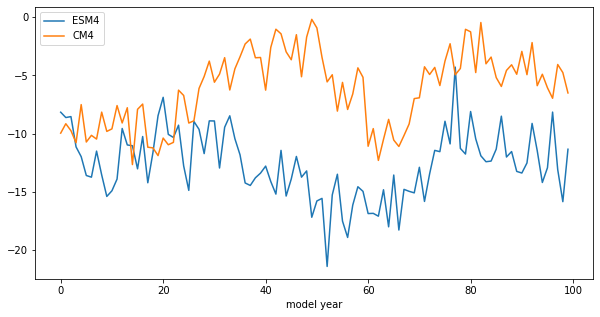

In [108]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(umo_esm4_sum,label='ESM4')
ax.plot(umo_cm4_sum,label='CM4')
ax.legend()
ax.set_xlabel('model year')